## Introduction
Over the course of this semester, I have been attending my local university’s Physics Colloquium, held on Fridays. The talks have ranged from “Femtosecond Spectroscopies” to “Galaxy Clusters as Dark Matter Laboratories,” with everything in between. The astrophysics presentations particularly caught my attention because of the unprecedented volume of data being collected in recent years. Although my background is in computer science rather than astrophysics, this data-driven frontier piqued my interest.  

When it came time to choose a project for this class, I wanted an astrophysical problem that could use a machine-learning approach. I decided to build a model that predicts galaxy distances from the Sloan Digital Sky Survey’s photometric measurements. This effort builds upon the traditional “cosmic distance ladder”. Since 240 BC when Eratosthenes calculated the circumference of the Earth, humans have been looking towards the sky to understand the universe. After using the parallax method to find the distance of local planets and stars, this method only took us so far and we've turned to determining distance based off of luminosity and photometric data of galaxies and comparing that with different objects with known distance and luminosity. 

## Project Topic
In this final project, our supervised models will estimate galaxy distances using spectroscopic redshift. Redshift is known as the color-shift a galaxy gives off as it moves farther away from us. As the galaxy moves farther from us the light waves get longer and for the galaxy to look more red. If a galaxy is coming closer to us it has a blueshift. Redshift is calculated by comparing the spectroscopic analysis of a known galaxy with an unknown galaxy and the difference in absorption lines are used to determine redshift. Interestingly you can think of this as the Doppler Effect but for light instead of sound waves.  

Then Hubble's Law is used to determine how far the galaxy is. Hubble Law states that the farther away a galaxy is from us, the faster it is moving away. Hubble's Law is formally written as 
$$
v = {H_0}{D}
$$
Where v is the galaxy's velocity, H_0 is the Hubble constant rate of expansion for the universe, and D is the distance to the galaxy. We know that there is a linear relationship between the distance of a galaxy and its speed moving away from us if it has a redshift(towards us if it has a blueshift). We can calculate the velocity as 
$$
v \approx c \, z
$$
where c is the speed of light, and z is the redshift. Now we can rewrite the distance of a galaxy as $$
D = \frac{v}{H_0}
$$
So why use machine learning when we can compute D directly? Calculating the redshift of each galaxy takes a lot of time. It is accurate but to calculate the redshift of hundreds of millions of galaxies will take a lot of time and a lot of resources. The learning algorithms that we will apply are linear regression, k-nearest neighbors, random forest, and boosting. This approach can dramatically accelerate large-scale distance estimates and reveal which algorithms and hyperparameter settings perform best on SDSS photometry.

Github: https://github.com/sam-ghala/galaxy_distance/tree/main

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from astroquery.sdss import SDSS
from scipy.stats import gaussian_kde
from astropy.table import Table, vstack
from scipy.stats import randint, uniform
from pandas.plotting import scatter_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

## Data Source
The dataset for this project comes from the Sloan Digital Sky Survey, on the homepage of their website they note that they have "created the most detailed three-dimensional maps of the Universe ever made, with deep multi-color images of one third of the sky, and spectra for more than three million astronomical objects." It is a public source and I downloaded the data from the python library astroquery.sdss. This library takes in SQL queries to the SDSS Data Release 18 and allows 10 minutes to gather the data(mine did not take the full 10 minutes). You can also run any SQL query directly on the SDSS site [4]. I performed two main queries, Retrieve galaxy model magnitudes in the u, g, r, i, z bands and one to gather the associated magnitude uncertainties. The maximum size query you can make is 500000 so I took 5 queries from redshifts of 0 to 1. The query had the condition that it must join the photo object catalog with the spectroscopic match. Then we filtered for objects classified as galaxies. The results were saved to CSV files and loaded into pandas DataFrames for processing.

| Redshift Range | Rows Retrieved |
|:--------------:|---------------:|
| 0.0 ≤ z < 0.1  |        409,566 |
| 0.1 ≤ z < 0.2  |        396,491 |
| 0.2 ≤ z < 0.3  |        192,958 |
| 0.3 ≤ z < 0.5  |        500,000 |
| 0.5 ≤ z < 1.0  |        500,000 |

<div align="center">
<em>Total rows after stacking:1,999,015</em>
</div>

In [2]:
# def fetch_data(redshift_min, redshift_max):
#     sql = f"""
#       SELECT TOP 500000
#         p.modelMag_u     AS u,   p.modelMagErr_u  AS u_err,
#         p.modelMag_g     AS g,   p.modelMagErr_g  AS g_err,
#         p.modelMag_r     AS r,   p.modelMagErr_r  AS r_err,
#         p.modelMag_i     AS i,   p.modelMagErr_i  AS i_err,
#         p.modelMag_z     AS z,   p.modelMagErr_z  AS z_err,
#         s.z              AS redshift
#       FROM PhotoObj AS p
#       JOIN SpecObj  AS s ON s.bestObjID = p.objID
#       WHERE s.class = 'GALAXY'
#         AND s.z BETWEEN {redshift_min} AND {redshift_max}
#     """
#     return SDSS.query_sql(sql, data_release=18, timeout=600)

# bins = [(0.00,0.10), (0.10,0.20), (0.20,0.30),
#         (0.30,0.50), (0.50,1.00)]
# tables = []
# for redshift_min, redshift_max in bins:
#     tbl = fetch_data(redshift_min, redshift_max)
#     print("Fetched {len(tbl)} rows for {redshift_min} ≤ z < {redshift_max}".format(len(tbl), redshift_min, redshift_max))
#     tables.append(tbl)

# full_tbl = vstack(tables)
# print("Total rows after stacking:", len(full_tbl))

# df = full_tbl.to_pandas()
# df.to_csv('sdss_galaxies_error_full.csv', index=False)
# print("Saved to sdss_galaxies_error_full.csv")


## Data Description and Data Cleaning
From the astroquery library we downloaded close to two million data points with 11 features for each galaxy entry. The features consisted of 
These include:  
- **Five photometric bands** (u, g, r, i, z) that sample the galaxy’s spectral energy distribution  
- **Five associated uncertainty measurements** (u_err, g_err, r_err, i_err, z_err)  
- **One spectroscopic redshift** (our target variable)  
After taking a quick look at the data we can immediately tell that there are some empty values but SDSS chooses to impute a value of -9999 if they have an empty value. Because our dataset is close to 2 million rows, we opted to drop the entries affected by these fill values rather than impute them. All fields are stored as floating-point numbers. All datatypes we have are floating point numbers. At first I only pulled the five color bands from the SDSS but after further inspection of the SDSS website I learned that they also included uncertainty in their measurements which could be valuable for cleaning the data.  

Inspecting the redshift column of our dataset we found that SDSS typically gives a redshift of 0 for objects that are very near or galaxies that have a failed fit. In theory a redshift of 0 means the galaxy or object is neither moving away from us or towards us so the color distortion is non-existent. The scope of this project isn't to inspect irregularities in the data but to predict the distance of well measured galaxies so we chose to drop values who have a redshift less than 0.01 and greater than 1. Although SDSS spectroscopy is optimized for 0.3 ≲ z ≲ 0.8, we allowed a wider range, relying on our uncertainty filters to ensure reliability even at the tail end.  

The redshift plots confirm the literature in that there is a relationship between redshifts of galaxies farther away and the higher uncertaintiy in their measurement.he pairplot also revealed a pronounced “edge” of high uncertainty measurements tracing back to residual missing values so we enforced a signal to noise ratio cut by requiring each band error < 0.2 (S/N > 5). Finally, we removed any objects fainter than the median 5-σ depth in each band:

| Band | Median 5 σ Depth (mag) |
|:----:|:----------------------:|
| u    | 22.15                  |
| g    | 23.13                  |
| r    | 22.70                  |
| i    | 22.20                  |
| z    | 20.71                  |

<div align="center">
<em>Table 1: Median 5-sigma point-source depths in the SDSS ugriz bands.</em>
</div>

### Data Cleaning Summary
Over the course of this project the data cleaning has become an iterative process, we would clean a subset of the data, fit our models, evaluate performance, and then refine the cleaning procedures to improve hyperparameter tuning and overall fit. To enrich our feature set, we also constructed the four color indices (u−g, g−r, r−i, i−z) from the cleaned magnitudes. By the end we dropped values that SDSS set as -9999 or 0, and trimmed data that didn't meet a signal to noise threshold. In terms of our project we removed galaxies that had uncertain measurements, galaxies that didn't have complete measurements and galaxies that are likely misclassified as close stars. Our dataset in this process was reduced from 1,999,015 to 775,093 galaxies.

Initial shape of data: (1999015, 11)
Feature names: Index(['u', 'u_err', 'g', 'g_err', 'r', 'r_err', 'i', 'i_err', 'z', 'z_err',
       'redshift'],
      dtype='object')
          u     u_err         g     g_err         r     r_err         i  \
0  17.61444  0.020139  16.17125  0.003434  15.52131  0.003031  15.15564   
1  20.26043  0.062698  19.02534  0.011079  18.56368  0.010292  18.32345   
2  20.56609  0.080824  19.24695  0.013191  18.58226  0.010763  18.27248   

      i_err         z     z_err  redshift  
0  0.003031  14.86996  0.007022  0.025475  
1  0.011720  18.17825  0.032135  0.023895  
2  0.011481  17.99068  0.028993  0.025029  
                  u         u_err             g         g_err             r  \
count  1.999015e+06  1.999015e+06  1.999015e+06  1.999015e+06  1.999015e+06   
mean   2.168616e+01  2.341149e-01  1.987606e+01 -2.381975e-01  1.866508e+01   
std    5.849234e+01  5.832354e+01  5.760734e+01  5.745386e+01  5.063155e+01   
min   -9.999000e+03 -9.999000e+03 -9

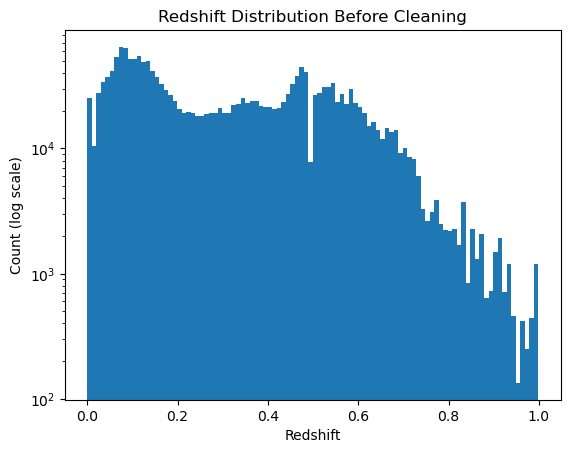

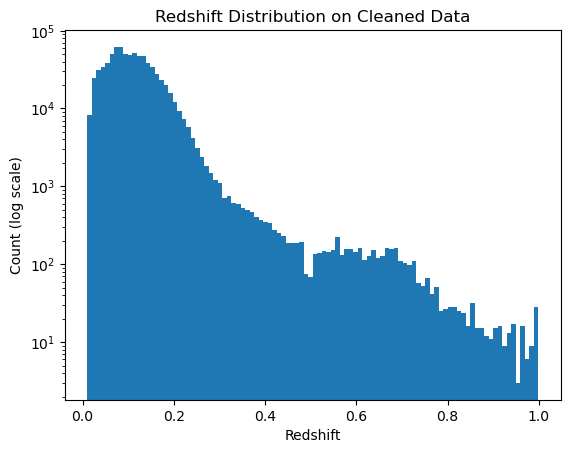

Cleaned shape of data: (775093, 15)


In [3]:
df_raw = pd.read_csv('sdss_galaxies_error_full.csv')
df = pd.read_csv('sdss_galaxies_error_full.csv')
# replace SDSS fill-values and drop NaNs
print("Initial shape of data: {}".format(df.shape))
print("Feature names: {}".format(df.columns))
print(df.head(3))
print(df.describe())
print(df.dtypes)
df_cols = ['u','g','r','i','z','u_err','g_err','r_err','i_err','z_err']
df.replace(-9999, np.nan, inplace=True)
missing_counts = df[df_cols].isna().sum()
print("Missing per column:\n", missing_counts)
df.dropna(subset=df_cols, inplace=True)


# noise ratio/uncertanity in error which is less than 0.2
err_cols = ['u_err','g_err','r_err','i_err','z_err']
print(df.describe())
# takes out most of the data
df = df[(df[err_cols] < 0.2).all(axis=1)] # keep values whose all 5 bands are above 0.2 noise

# band-specific depth limits, per band
# also removes a lot of the data
depth_limits = {'u':22.0,'g':23.1,'r':22.7,'i':22.2,'z':21.3}
for band, lim in depth_limits.items():
    df = df[df[band] < lim]

# build color features off of clean data, these are the color bands inbetween each band, just to add more features
df['u_g'] = df['u'] - df['g']
df['g_r'] = df['g'] - df['r']
df['r_i'] = df['r'] - df['i']
df['i_z'] = df['i'] - df['z']

band_features = ['u','g','r','i','z']
color_features = band_features + ['u_g','g_r','r_i','i_z']

print("Redshift range:", df['redshift'].min(), "–", df['redshift'].max())
df = df[df['redshift'] > 0] # remove 0 redshift galaxies 
plt.hist(df_raw['redshift'], bins=100, log=True)
plt.xlabel('Redshift')
plt.ylabel('Count (log scale)')
plt.title('Redshift Distribution Before Cleaning')
plt.show()

df = df[(df['redshift'] > 0.01) & (df['redshift'] < 1)]
plt.hist(df['redshift'], bins=100, log=True)
plt.xlabel('Redshift')
plt.ylabel('Count (log scale)')
plt.title('Redshift Distribution on Cleaned Data')
plt.show()

print("Cleaned shape of data: {}".format(df.shape))

## Exploratory Data Analysis
Our prior cleaning process gave us a strong sense of the correlation between the photometric features. Our first figure overlays kernel density estimates (KDEs) for the five ugriz bands, it showed the true spectrum of our data. When one band’s density tapers off, the next band peaks. The magnitude range spans approximately 13–22 mag; the u-band peaks at brighter magnitudes (shallowest depth), whereas the z-band peaks at fainter magnitudes, reflecting the redder spectral energy distribution of most galaxies. The second figure plots the mixed colors KDEs. We can see that the u−g and g−r distributions overlap closely, as well as the r−i and i−z distributions, indicating strong covariance in adjacent colors.  

We then produced a pairplot (scatter‐matrix) to examine feature relationships. Next we plotted a pairplot where each off-diagonal panel shows a 2D scatter of one feature vs. another and the diagonal panels are their marginal histograms. We can also see a strong correlation between the five main bands and themselves. The color differences in the bottom right 4x4 shows up as "clouds". The tightness of the cloud quantifies how strongly correlated those features are r-i vs i–z being extremely tight.

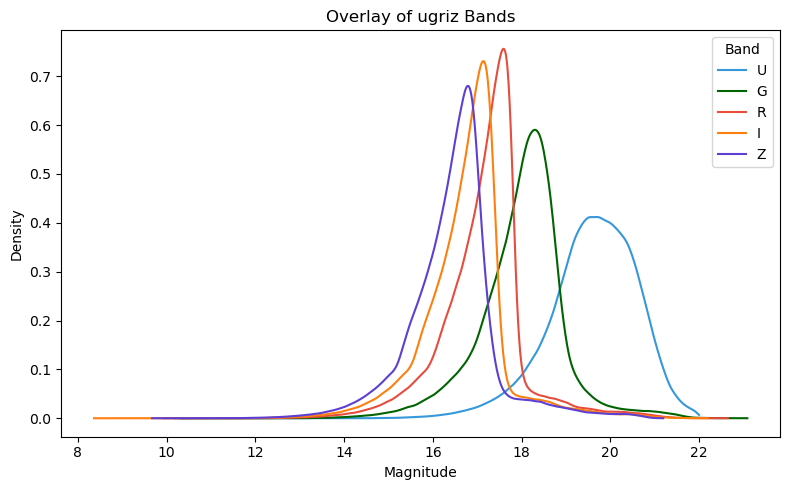

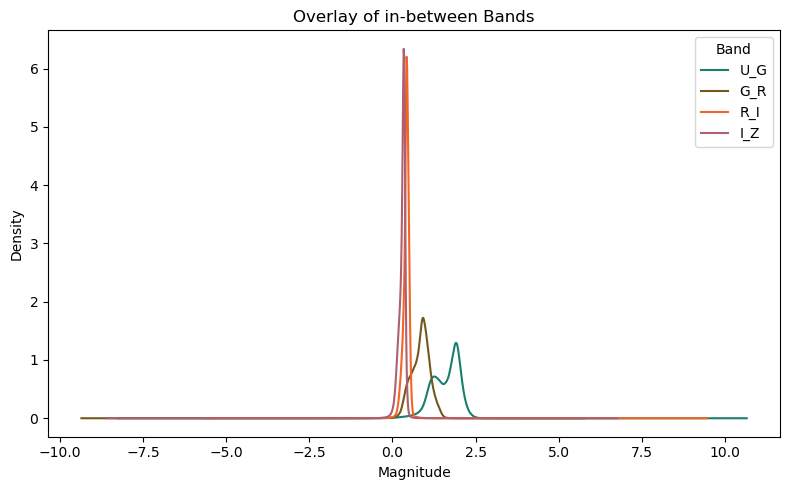

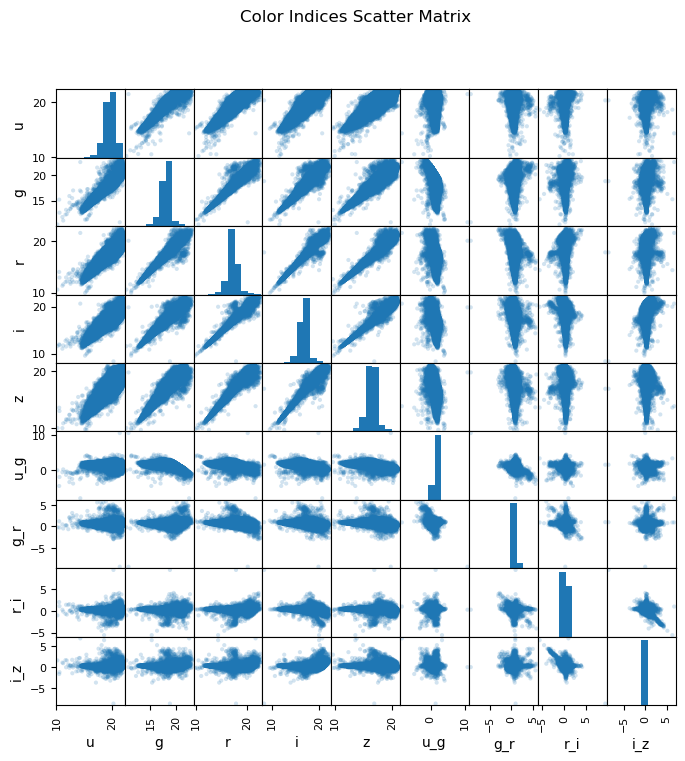

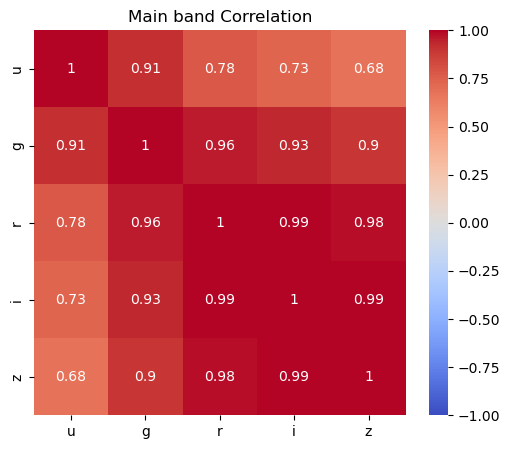

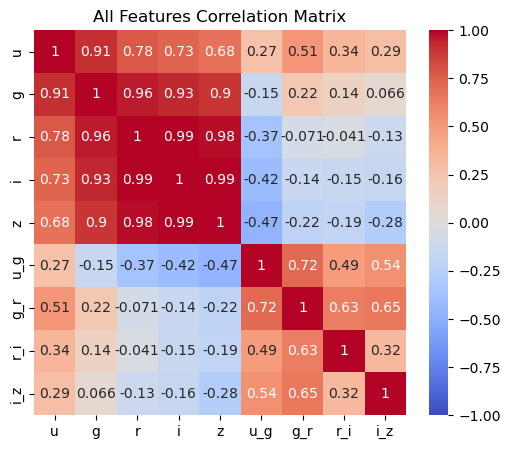

In [4]:
band_colors = {
    'u': '#3498DB',  # mid blue hex
    'g': '#006400',  # dark green hex
    'r': '#e74c3c',  # red
    'i': '#ff7f0e',  # orange
    'z': '#5D3FD3',  # light purple hex
    # inbetween colors
    'u_g': '#1A7E6D',  
    'g_r': '#73581E', 
    'r_i': '#F36525',
    'i_z': '#AE5F70',
}

plt.figure(figsize=(8,5))
for band in band_features:
    data = df[band]
    kde  = gaussian_kde(data) # for its smooth curve
    x    = np.linspace(data.min(), data.max(), 1000)
    y    = kde(x)
    plt.plot(x, y, color=band_colors[band], lw=1.5, label=band.upper())

plt.xlabel('Magnitude')
plt.ylabel('Density')
plt.title('Overlay of ugriz Bands')
plt.legend(title='Band')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
for band in color_features[5:]:
    data = df[band]
    kde  = gaussian_kde(data)
    x    = np.linspace(data.min(), data.max(), 1000)
    y    = kde(x)
    plt.plot(x, y, color=band_colors[band], lw=1.5, label=band.upper())

plt.xlabel('Magnitude')
plt.ylabel('Density')
plt.title('Overlay of in-between Bands')
plt.legend(title='Band')
plt.tight_layout()
plt.show()


# pairplot 
scatter_matrix(df[color_features], alpha=0.2, figsize=(8,8))
plt.suptitle('Color Indices Scatter Matrix')
plt.show()

# Correlation Matrix
plt.figure(figsize=(6,5))
sns.heatmap(df[band_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Main band Correlation')
plt.show()

# Correlation Matrix
plt.figure(figsize=(6,5))
sns.heatmap(df[color_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('All Features Correlation Matrix')
plt.show()



## Models
### Linear Regression
After cleaning the data, separating the redshift labels from the nine photometric and color features, scaling all predictors, and splitting into an 80/20 train/validation set, we applied mixed feature selection. We optimized for cross-validated R² and used both forward/backward and floating search methods (SFS, SBS, SFFS, SBFS) with 5-fold CV and n_jobs=-1 to leverage all CPU cores. The optimal subset comprised five features g, i, u−g, g−r, and i−z.  

Fitting a multivariate linear regression model on these features, we observed from the learning curves that training and validation errors converge at large sample sizes—an indication of bias. A variance inflation factor (VIF) analysis revealed high multicollinearity among the predictors. Residual plots showed also showed heteroscedasticity, signaling that a the linear regression model misses some of the nuances in photometry–redshift mapping.  

Based on everything we know so far we can tell that a linear model is too ridged to fit to the data and the multicollinearity makes this model unstable. We will now look into other models to see if we can increase our performance metrics. 

Stepwise selected: ['g', 'i', 'u_g', 'g_r', 'i_z']
MAE:      0.0263
RMSE:     0.0444
R²:       0.6079


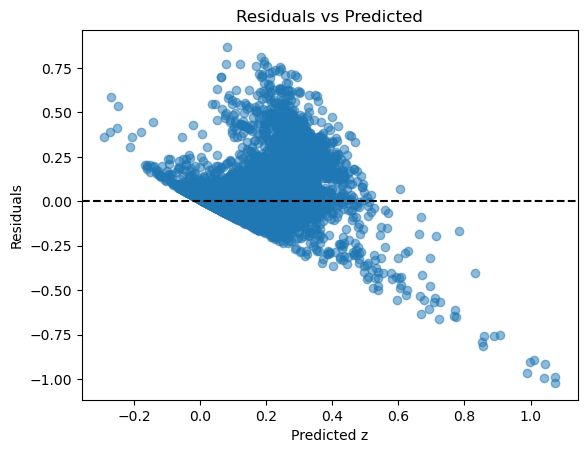

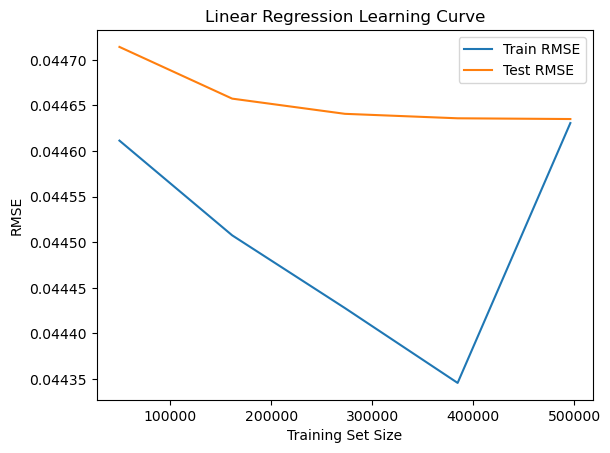

  feature         VIF
0   const         NaN
1       u  134.541277
2       g  131.312812
3       r    2.623733
4       i   20.643423
5       z    1.820724
                            OLS Regression Results                            
Dep. Variable:               redshift   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                 1.884e+05
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:57:53   Log-Likelihood:             1.0482e+06
No. Observations:              620074   AIC:                        -2.096e+06
Df Residuals:                  620068   BIC:                        -2.096e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|  

In [5]:
X = df[color_features]
y = df['redshift']
model_runtime = {}
# scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

lr = LinearRegression()
# mixed selection
sfs_floating = SFS(
    lr,
    k_features=5,
    forward=True,
    floating=True,      # allows features to go in and out
    scoring='r2',
    cv=5,
    n_jobs=-1
)
sfs_floating = sfs_floating.fit(X_train, y_train)

selected_floating = list(sfs_floating.k_feature_names_)
selected_floating = [color_features[int(i)] for i in selected_floating]
print("Stepwise selected:", selected_floating)

mask = [c in selected_floating for c in X.columns]


linear_X_train = X_train[:, mask]
start = time.perf_counter()
lr.fit(linear_X_train, y_train)

y_pred = lr.predict(X_test[:, mask])
end = time.perf_counter()
model_runtime['Linear Regression'] = end-start

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = lr.score(X_test[:,mask], y_test)

# print them all
print("MAE:      {:.4f}".format(mae))
print("RMSE:     {:.4f}".format(rmse))
print("R²:       {:.4f}".format(r2))

# residuals plot
residuals = y_test - y_pred
plt.figure()
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicted z')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()
# learning curve
train_sizes, train_scores, test_scores = learning_curve(
    lr, linear_X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1,1.0,5)
)
train_rmse = np.sqrt(-train_scores)
test_rmse  = np.sqrt(-test_scores)
plt.figure()
plt.plot(train_sizes, train_rmse.mean(axis=1), label='Train RMSE')
plt.plot(train_sizes, test_rmse.mean(axis=1), label='Test RMSE')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Linear Regression Learning Curve')
plt.legend()
plt.show()

# variance inflation factor
vif_data = pd.DataFrame({
    'feature': ['const'] + list(band_features),
    'VIF': [np.nan] + [
        variance_inflation_factor(linear_X_train, i)
        for i in range(len(band_features))
    ]
})
print(vif_data)
# OLS Summary
X_train_sm = sm.add_constant(linear_X_train)
ols = sm.OLS(y_train, X_train_sm).fit()
print(ols.summary())

### KNN Regressor
Next, we applied the k-nearest neighbors (KNN) regressor due to its flexibility in modeling non-linear relationships. We conducted a grid search over 12 values of k, evenly spaced from 2 to 30, using 5-fold cross-validation on the training set. Each candidate model was evaluated using mean squared error and specified distance weighting. The optimal parameter was k = 24.  

On the validation set, the true vs. predicted redshift plot shows most points clustered along the y=x line, with a moderate number of outliers drifting off the line indicating residual error. The learning curve demonstrates no signs of overfitting—training and validation errors both decline as the training size increases but didn't converge at the maximum training size. 

/Users/samghalayini/miniconda3/envs/galaxy_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best k: 30
KNN MAE: 0.0174
KNN RMSE: 0.0304
KNN R²: 0.8160


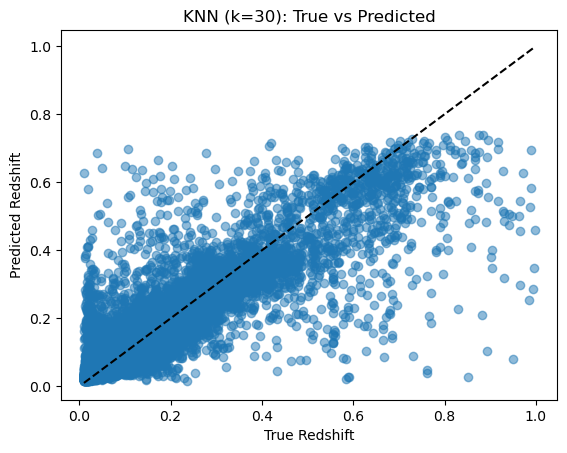

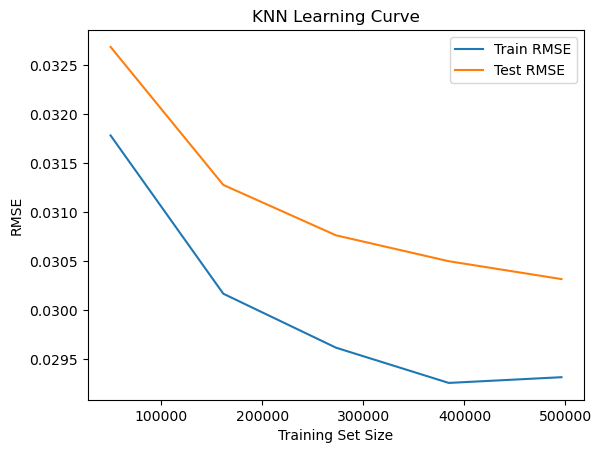

In [6]:
param_grid = {'n_neighbors': np.linspace(2,30,12, dtype=int)}
start = time.perf_counter()
grid = GridSearchCV(KNeighborsRegressor(weights='distance', algorithm='auto'), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)
end = time.perf_counter()
model_runtime['KNN Grid Search'] = end-start
best_k = grid.best_params_['n_neighbors']
print("Best k: {}".format(best_k))

knn = KNeighborsRegressor(n_neighbors=best_k)
start = time.perf_counter()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
end = time.perf_counter()
model_runtime['KNN'] = end-start

# Performance Metrics
mae_knn  = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn   = r2_score(y_test, y_pred_knn)
print("KNN MAE: {:.4f}".format(mae_knn))
print("KNN RMSE: {:.4f}".format(rmse_knn))
print("KNN R²: {:.4f}".format(r2_knn))


plt.figure()
plt.scatter(y_test, y_pred_knn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('KNN (k={}): True vs Predicted'.format(best_k))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    knn, X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1,1.0,5))
train_rmse = np.sqrt(-train_scores)
test_rmse  = np.sqrt(-test_scores)
plt.figure()
plt.plot(train_sizes, train_rmse.mean(axis=1), label='Train RMSE')
plt.plot(train_sizes, test_rmse.mean(axis=1), label='Test RMSE')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('KNN Learning Curve')
plt.legend()
plt.show()

### Random Forest
To explore an ensemble-based, non-linear model, we implemented a Random Forest Regressor and tuned its hyperparameters via RandomizedSearchCV. A full grid search would've taken much too long, so I defined the following sampling paramters as the number of trees in the forest, maximum depth of each tree, and the cost-complexity pruning parameter.  

Each tree was trained on a bootstrap sample of the data, considering only sqrt(n) features per split. We used 5-fold cross-validation and limited the randomized search to 5 iterations to keep total training time under ≈ 30 minutes. The other tested parameters turned my laptop into a furnace. This configuration tuned the hyperparameter space with practical runtime constraints for my laptop.

In [7]:
param_dist = {
    'n_estimators': randint(10, 101),      # integers 50–300
    'max_depth':    randint(3,21),        # 5–50
    'ccp_alpha':    uniform(0, 0.001)      # continuous [0,0.001]
}

rf = RandomForestRegressor(
    oob_score=True,
    random_state=42,
    max_features='sqrt',   # feature‐sampling
    bootstrap=True, 
    n_jobs=-1,
    verbose=0
)
rs = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,                # only 5 combinations
    cv=5,                     # 5‐fold CV
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=0,
    verbose=0
)
start = time.perf_counter()
rf = rs.fit(X_train, y_train)

print("Best RF params:", rf.get_params)

# evaluate on held‐out test set
y_pred_rf = rf.predict(X_test)
end = time.perf_counter()
model_runtime['Random Forest'] = end-start

# Performance Metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print("MAE: {:.4f}".format(mae_rf))
print("RMSE: {:.4f}".format(rmse_rf))
print("R²: {:.4f}".format(r2_rf))

/Users/samghalayini/miniconda3/envs/galaxy_env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/samghalayini/miniconda3/envs/galaxy_env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/samghalayini/miniconda3/envs/galaxy_env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/samghalayini/miniconda3/envs/galaxy_env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Use

Best RF params: <bound method BaseEstimator.get_params of RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_features='sqrt',
                                                   n_jobs=-1, oob_score=True,
                                                   random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3735ee850>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x373821fd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3735ed290>},
                   random_state=0, scoring='neg_mean_squared_error')>
MAE: 0.0374
RMSE: 0.0522
R²: 0.4565


### Boosting
Finally, we trained an XGBoost regressor. Like the Random Forest, it requires minimal upfront feature selection but trains much faster than RF. It also introduces a larger hyperparameter space of learning_rate, n_estimators, max_depth. We chose boosting because each tree in the sequence learns to correct the residuals of its predecessors, allowing the model to capture non-linear relationships of the spectral bands.

The built-in gain plot shows that the g-band magnitude contributes the largest average reduction in training loss, followed by the g−r and u−g color indices. What is interesting is that many of the same features (g, g-r, u-g) that were picked with mixed selection for linear regression was also picked for the boosting.


XGB RMSE: 0.0307
XGB MAE: 0.0176
XGB R²: 0.8126


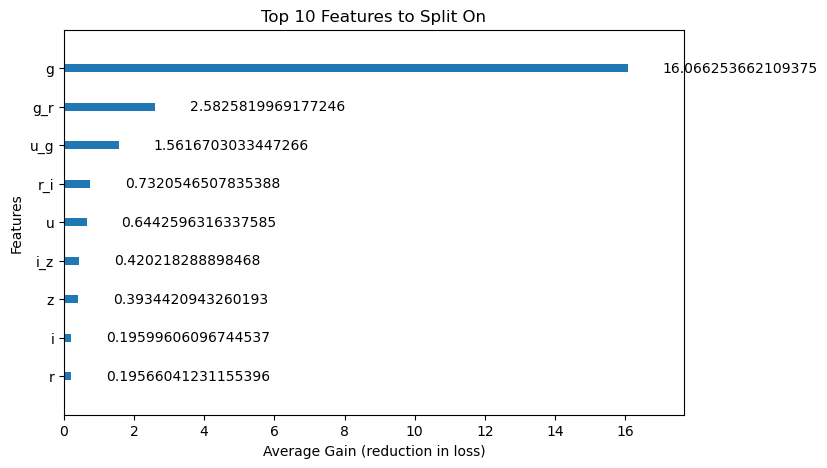

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df[color_features],
    df['redshift'],
    test_size=0.2,
    random_state=42
)
xgb_reg = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    eval_metric='rmse',
    random_state=42,
    n_jobs=-1,
    verbosity=0)

start = time.perf_counter()
xgb_reg.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=0)

y_pred = xgb_reg.predict(X_test)
end = time.perf_counter()
model_runtime['XGBoost'] = end-start

# Performance Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print("XGB RMSE: {:.4f}".format(rmse))
print("XGB MAE: {:.4f}".format(mae))
print("XGB R²: {:.4f}".format(r2))

fig, ax = plt.subplots(figsize=(8,5))
xgb.plot_importance(xgb_reg, max_num_features=10, importance_type='gain', ax=ax)
ax.grid(False)
plt.title("Top 10 Features to Split On")
ax.set_xlabel("Average Gain (reduction in loss)")
plt.show()


In [9]:
print(model_runtime)

{'Linear Regression': 0.03220454198890366, 'KNN Grid Search': 75.59658137502265, 'KNN': 8.33616470900597, 'Random Forest': 300.36440133300493, 'XGBoost': 1.9197679590142798}


## Results and Analysis

| Model               |   MAE  |  RMSE  |   R²   | Time (s) |
|:--------------------|-------:|-------:|-------:|---------:|
| Linear Regression   | 0.0263 | 0.0444 | 0.6079 |   0.0283 |
| KNN (k=24)          | 0.0180 | 0.0311 | 0.8076 |   5.1731 |
| Random Forest       | 0.0374 | 0.0522 | 0.4565 | 353.6183 |
| XGBoost             | 0.0176 | 0.0307 | 0.8126 |   1.9744 |

In our redshift experiments, XGBoost delivered the best balance of accuracy and speed, achieving the lowest MAE = 0.0176, lowest RMSE = 0.0307, highest R² = 0.8126, and a fast training time 2s. KNN performed nearly as well with metrics of MAE = 0.0180, RMSE = 0.0311, R² = 0.8076 but took longer to run. Linear regression under‐fits the non‐linear color–redshift relationship R² = 0.61, while random forest showed weaker performance R² = 0.46 and took a very long time to train 350s. Overall, gradient boosting with XGBoost is the clear winner for mapping SDSS ugriz photometry to galaxy redshift.  


## Discussion 

This project taught me how humanity is continually reaching for the next rung on the “cosmic ladder.” The most important takeaway was that data cleaning and feature processing drive model performance by removing bad records and utilizing the uncertainty measurements. Through the iterative process of cleaning and fitting a model each successive generation outperformed its predecessors. Working through linear regression, KNN, random forest, and XGBoost revealed the strengths and weaknesses of each. The process also gave me experience in seeing where where rigid, parametric models break down and where more flexible ensembles demand careful hyperparameter tuning.  

Future improvements might include:  
- Incorporating additional SDSS bands (and external surveys) to enrich the feature set  
- Scaling up hyperparameter searches via cloud computing resources  
- Applying dimensionality-reduction techniques (e.g. PCA) or automatic feature extraction  
- Implementing more robust outlier-detection strategies  



### Refrences
**APA and Links**  
1. Almeida, A., Anderson, S. F., Argudo-Fernández, M., Badenes, C., Barger, K., Barrera-Ballesteros, J. K., Bender, C. F., Benitez, E., Besser, F., Bird, J. C., Bizyaev, D., Blanton, M. R., Bochanski, J., Bovy, J., Brandt, W. N., Brownstein, J. R., Buchner, J., Bulbul, E., Burchett, J. N., … Zasowski, G. (2023). The Eighteenth Data Release of the Sloan Digital Sky Surveys: Targeting and First Spectra from SDSS-V. The Astrophysical Journal Supplement Series, 267(2), 44. https://doi.org/10.3847/1538-4365/acda98
2. Sloan Digital Sky Survey. (2023). _SDSS Data Release 18_. Retrieved April 10, 2025, from https://www.sdss.org/dr18/
<!-- **Links**   -->
3. https://www.sdss4.org/dr15/imaging/other_info/  
4. https://skyserver.sdss.org/dr18/SearchTools/SQL/  
5. https://www.cosmos.esa.int/documents/401090/430753/VOSpec_Redshift_Tutorial.pdf  
6. https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/  
7. https://skyserver.sdss.org/dr18/SearchTools  

In [10]:
# #  Notes:
# # I always suscpected the connection but never actually looked up the reason why 
# # random states are commonly set to 42 is a refrence to the book "HitchHikers Guide 
# # to the Galaxy" because it is the answer to the "Ultimate Question of Life, the 
# # Universe, and Everything".

# Old loading data
# sql = """ 
#   SELECT TOP 500000
#     p.modelMag_u     AS u,   p.modelMagErr_u  AS u_err,
#     p.modelMag_g     AS g,   p.modelMagErr_g  AS g_err,
#     p.modelMag_r     AS r,   p.modelMagErr_r  AS r_err,
#     p.modelMag_i     AS i,   p.modelMagErr_i  AS i_err,
#     p.modelMag_z     AS z,   p.modelMagErr_z  AS z_err,
#     s.z              AS redshift
#   FROM PhotoObj AS p
#   JOIN SpecObj  AS s ON s.bestObjID = p.objID
#   WHERE s.class = 'GALAXY'
# """

# tbl = SDSS.query_sql(sql, data_release=18, timeout=600)

# print("Received {} rows".format(len(tbl)))
# Table(tbl).write('sdss_galaxies_error.csv', format='csv', overwrite=True)